---
title: "Chapter 2, Part 6: Support Vector Machines"
ssubtitle: "Machine Learning"
date: "January 2026"
date-format: "MMMM YYYY"
author: 
  - F.San Segundo & N.Rodríguez
bibliography: ../exclude/mlmiin.bib
execute:
  echo: true
code-overflow: wrap
format: 
  html: 
    toc: true
    code-tools: true
    code-fold: show
    code-summary: "Hide the code"
    embed-resources: true
---

---

# Session Setup

::: {.callout-note  icon=false}

### Libraries

Let us begin my loading the libraries we will use.

:::



In [1]:
### Load necessary modules -------------------------------
# interactive plotting
# %matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

# others
import math
from statsmodels.stats import contingency_tables as cont_tab
from scipy.stats import binomtest

import warnings

::: {.callout-important}

## COPY THIS NOTEBOOK FIRST

<h2 style="color:blue; font-weight:bold;">Checklist</h2>

+ Have you started Docker Desktop?
+ Have you launched Docker from the `MLMIIN` repository folder?
+ Have you connected VS Code to the running container?

If you have missed any of these steps you may need to restart VS Code after completing them.  
Also if Python seems unresponsive at first, try restarting the kernel.

<h2 style="color:red; font-weight:bold;">IMPORTANT</h2>

+ Remember to **make a copy of this notebook** (in the same folder) before starting to work on it.
+ If you make changes to the original notebook, save it with another name, and use Git to undo the changes in the original notebook (ask for help with this if you need it).

:::  
 

::: {.callout-warning icon=false}

##### Setting the working directory

We begin by using cd to make sure we are in the right folder.

:::

In [2]:
%cd 2_6_SupportVectorMachines/

/wd/2_6_SupportVectorMachines


---

# Introduction: Linearly Separable Problems


::: {.callout-note  icon=false}

### Linearly Separable Classification Problems

In previous sessions we have already seen several examples of linearly as well as non linearly separable classification problems. To help us visualize the following discussion, we begin by generating a synthetic example of a two dimensional linearly separable problem. The following script does that and plots the resulting dataset.

:::

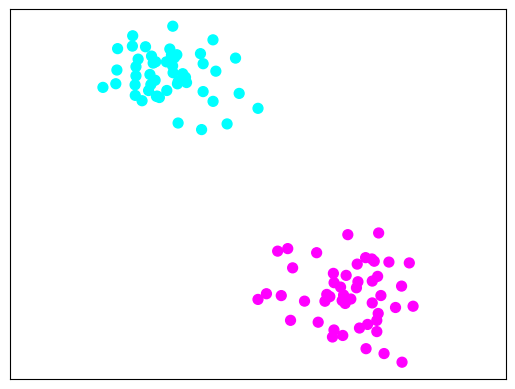

In [3]:
%run -i "./2_6_Glassner_Examples_01.py"

---


::: {.callout-note  icon=false}

### Linear Decision Boundaries and Hyperplanes

This example is linearly separable because we can use a straight line as the decision boundary of a classifier. The equation of the line would be:
$$\beta_0 + \beta_1 X_1 + \beta_2 X_2 = 0$$
The generalization of the straight line to higher dimensional problems is the **affine hyperspace** with equation (in dimension $p$):
$$\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p = 0$$
As the following figure illustrates, if a we can use a hyperplane as decision boundary, then there are infinitely many so called **separating hyperplanes**.

And that leads us to the natural question: is there some way to define **the best separating hyperplane, the one that separates both classes the most?**

:::

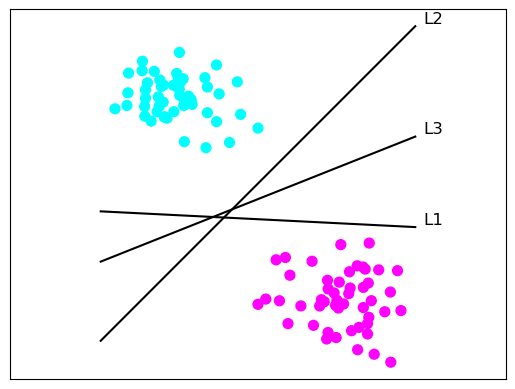

In [4]:
%run -i "./2_6_Glassner_Examples_02.py"

::: {.callout-tip  icon=false}

### Exercise 001

Which one of those three do you think is the best? Why?

:::

---


::: {.callout-note  icon=false}

### The Margin of a Separating Hyperplane. 

One way to compare separating hyperplanes is to think that we make the hyperplane *thicker* in the direction of its normal vector. The code in the next script illustrates this idea showing the **margin** for each of the separating hyperplanes. That is, we consider the $d$-offset region consisting of all points whose distance to the hyperplane is less than $d$. As we increase the value of $d$ we find that eventually the region can not become thicker, when it touches those data samples for which the distance to the separating hyperplane is minimal (surrounded by a black circle in the plots). This minimal distance from the dataset to the hyperplane is called the **margin** for the hyperplane.

:::

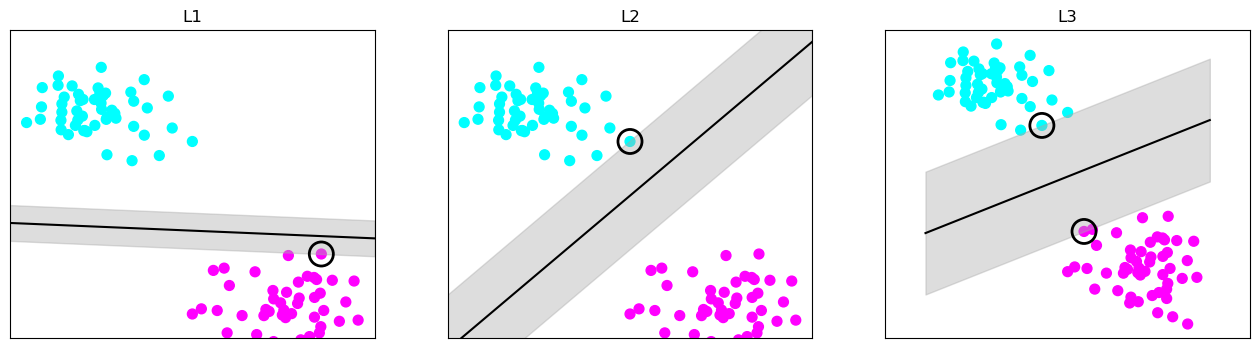

In [5]:
%run -i "./2_6_Glassner_Examples_03.py"

::: {.callout-note  icon=false}

### Maximal Margin and Support Vectors.

The margins of the three separating hyperplanes in these plots are clearly different and they provide an answer to our question: the **maximal margin** is defined to be the maximum value of the margin $d$ over all possible separating hyperplanes. 

The points surrounded by black circles in each plot are the **support vectors** for each hyperplane. These are the data points at a minimum distance of the hyperplane. 

A **very important** feature of this situation is that if you make a small perturbation of any data point that is **not** a support vector, then the maximal margin remains unchanged. Therefore the **maximal margin computation only depends on the coordinates of the support vectors**.

:::

---

::: {.callout-note  icon=false}

### Maximal Margin Classifier.

The following figure shows the maximal margin and the support vectors for the example dataset (the rightmost figure in previous paragraphs). 

If we define
$$f(X_1,\ldots, X_p) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p$$
and
$$f(X_1,\ldots, X_p) = 0$$
is the equation of a separating hyperplane, then the hyperplane itself can be thought of as the $0$-level set of $f$. And $f$ divides the space into two regions (shaded with different colors in the plot), according to the **sign of $f$**.

Note that, since each of the classes is entirely contained in one of those two regions, the sign of $f$ can be used to classify the points. This is called the **maximal margin classifier.**

:::

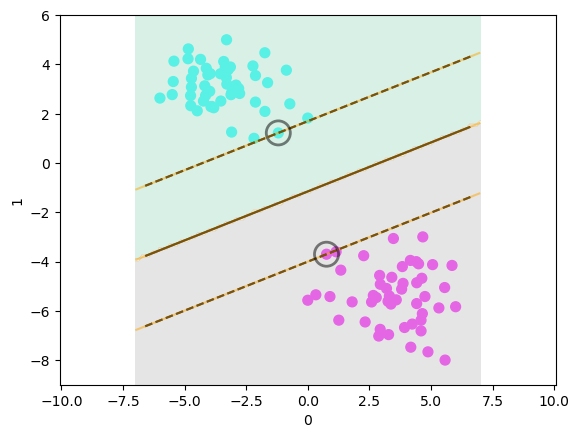

In [6]:
# %load "./2_6_Glassner_Examples_04.py"
%run -i "./2_6_Glassner_Examples_04.py"

---

::: {.callout-warning  icon=false}

### Transforming the Output `Y` to Formulate the Problem.

In the first sessions, when dealing with binary classification problems we have frequently used 0 and 1 to encode the two levels of the output variable `Y`. We met the alternative -1, 1 encoding in the previous session, when discussing boosting. Here again, in order to use the preceding remark about the sign of $f$ we will recode $Y$ so that the two levels are  -1 and 1 (so they both have a sign). 

:::


::: {.callout-note  icon=false}

### Using this Sign Encoding Combined with the Sign of $f$

To obtain the maximal margin classifier we need to find $f$ (i.e we need to find the maximal margin hyperplane). With the above mentioned output encoding we can select the class labels and hyperplane coefficients accordingly so that for all data points with inputs $X_1,\ldots, X_p$ and output $Y$:
$$\text{sign}(Y) = \text{sign}(f(X_1, \ldots, X_p)) = \text{sign}(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p)$$
Or,  in short (and this is the reason for the -1, 1 encoding):
$$Y \cdot (\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p) > 0$$
for all data points, irrespective of the value -1 or 1 of $Y$.

If we further require that 
$$\beta_1^2 + \beta_2^2 + \cdots + \beta_p^2 = 1$$ 
(note that $\beta_0$ is excluded) then $\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p$ can be directly interpreted as the *signed distance* from the point to the hyperplane. 

A hyperplane (with fixed $\beta$ values) is separating if we can find a value $M > 0$ such that  
$$Y \cdot (\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p) \geq M$$
holds in the dataset. The margin for that particular hyperplane is the maximum such $M$. And if we consider all hyperplanes (all possible $\beta$ values) this leads us directly to the following formulation. 

:::

---

::: {.callout-note  icon=false}

### Formulating The Maximal Margin Classifier as an Optimization Problem

The maximal margin classifier is the solution to this optimization problem. Find:
$$\text{argmax}_{\beta_0,\beta_0,\ldots,\beta_p}(M)$$
(that is find the $\beta$ values for which $M$ is maximum) subject to these conditions:
$$
\begin{cases}
Y \cdot (\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p) \geq M&\text{ for all data points ($n$ conditions).}\\
\beta_1^2 + \beta_2^2 + \cdots + \beta_p^2 = 1\\
M > 0
\end{cases}
$$

The advanced references mentioned at the beginning of this session contain more information about the optimization methods required for this problem.

:::

---

# Non Linearly Separable Problems


::: {.callout-note  icon=false}

### Extending the Maximal Margin Idea to Non Linearly Separable Problems

Before we look into the scikit implementation, we need to generalize the above discussion to those cases where a separating hyperplane does not exist. The plot below illustrates one such case. The two classes overlap in the `X1`, `X2` plane  in such a way that no straight line will do.

:::

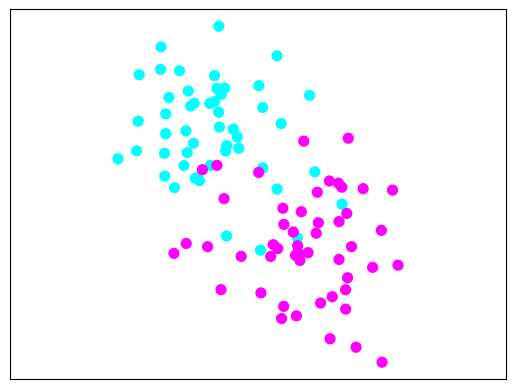

In [7]:
%run -i "./2_6_Glassner_Examples_05.py"

---


::: {.callout-note  icon=false}

### Allowing for Margin Trespassing

In order to extend the previous ideas to this kind of situations we will allow a certain number of data points to be **inside the margin**, or even to be in the **wrong side of the margin**. 

The following code and plot illustrate this idea. You can see that the notion of support vector is now generalized to include these new *inside margin* and *wrong side* categories. We will return below to the meaning of `C` here.

:::

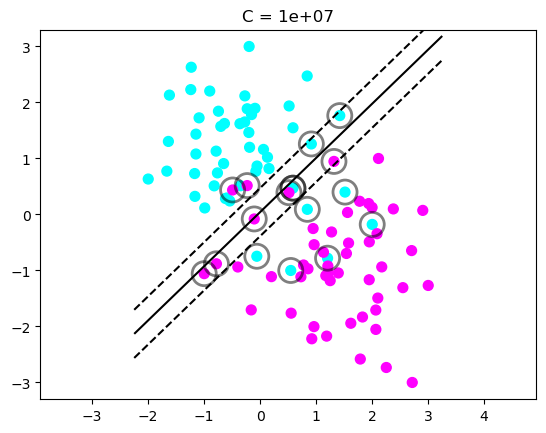

In [8]:
C = 1e07
model = SVC(kernel='linear', C=C)
model.fit(X_overlap, y_overlap)
decf_X = plot_boundary_and_support(X_overlap, y_overlap, model, 1, C, levels=np.arange(-1,1,0.5), 
                                   title=True, decisionRegion=False, contours=False)

---

::: {.callout-note  icon=false}

### The Slack Variables and Penalty Parameter Idea 

Of course, we still want the model to try its hardest to separate the classes. By allowing some amount of this *margin trespassing* we hope to get a model that generalizes well to new unseen data. To drive the model in that direction we will add a *penalty parameter*. The idea is that the model has to pay a price every time the margin is trespassed, and the price increases with the distance from the margin. 

To implement this idea we create a whole new set of so called **slack variables** $\epsilon_i\geq 0$, one for each data point with $i= 1,\ldots, n$. As indicated, these are assumed to be non negative and they measure the penalty allocated to each point. And to get a global computation of the total cost (total margin trespassing penalty) incurred by the model we consider the sum of these slack variables:
$$\sum_{i = 1}^n\epsilon_i$$ 

:::

::: {.callout-warning  icon=false}


### IMPORTANT: Interpretation of the C Penalty Parameter in Books vs scikit

The bibliographic references that we provide, and most of the theoretical descriptions of support vector machines that you will find define in this context a parameter $C$ as follows:
$$C = \sum_{i = 1}^n\epsilon_i$$
In that case, $C$ is directly interpreted the total cost incurred by the model. 

**But the [`SVC` classifier in scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (the one we use in this session) defines `C` to be the inverse of this sum:**
$$\dfrac{1}{C} = \sum_{i = 1}^n\epsilon_i$$
:::

::: {.callout-tip  icon=false}

### Exercise 002

Keeping the above warning in mind, experiment with the value of `C` in the previous code cell. What happens if you take a very small value of (scikit value of) `C` (that is, you allow the model a larger *trespassing budget*). 

:::

---

::: {.callout-note  icon=false}

### Bringing Slack Variables and Penalty Parameter into the Optimization Framework

Instead of requiring each data point to satisfy the *original margin condition*:
$$Y \cdot (\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p) > M$$
the introduction of the slack variables allows us to reformulate this as
$$Y \cdot (\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p) > M (1 - \epsilon_i)$$

Let us see how this works:
+ When $\epsilon_i = 0$ we are back in the original margin condition. This means that this point is placed on the side of the margin that corresponds to its class. This in particular includes the *standard support vectors* as we previously defined them.  
+ When $0 < \epsilon_i < 1$ the margin condition does not hold, and the point is *inside the margin*, deeper in as $\epsilon_i$ increases. It thus becomes one of a new kind of *support vectors*. 
+ At  $\epsilon_i = 1$ the point crosses the hyperplane when $f = 0$.
+ And for $\epsilon_i > 1$ the point is in the *wrong side the margin*, and belongs to the second new breed of *support vectors* for the model. 

Of course we expect most of the data points in the dataset to be sitting comfortably in their side of the margin, and that means they will have their $\epsilon_i = 0$ and will not be counted among these new kind of support vectors (a few can be *classical support vectors*). 

:::

---

::: {.callout-note  icon=false}

### A New Version of the Optimization Problem. Support Vector Classifier.

With the above ideas the **support vector classifier** is the solution to this new formulation of the optimization problem. Find:
$$\text{argmax}_{\beta_0,\beta_1,\ldots,\beta_p,\epsilon_0,\ldots,\epsilon_n}(M)$$
That is find the $\beta$ **as well as $\epsilon$** values for which $M$ is maximum) subject to these conditions:
$$
\begin{cases}
Y \cdot (\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p) > M (1 - \epsilon_i) & \text{ for all data points ($n$ conditions).}\\[2mm]
\beta_1^2 + \beta_2^2 + \cdots + \beta_p^2 = 1\\[2mm]
\sum_{i = 1}^n\epsilon_i \leq C & \textbf{Note: }\text{in scikit this would be }1/C\\[2mm]
M > 0
\end{cases}
$$
Here the **penalty parameter** $C$ is considered a hyperparameter of the model, to be optimized during model training. The **decision function** is
$$f(X_1,\ldots,X_p)  = \beta_0 + \beta_1 X_1 + \cdots +\beta_p X_p$$
and we use the sign of $f$ to make class predictions. This type of model is what we call a **support vector classifier.**

:::

::: {.callout-note  icon=false}

### C and the idea of Regularization

The introduction of the penalty parameter $C$ above is a clear example (and certainly not the last we will see) of the **regularization** techniques in Machine Learning. Regularization adds some sort of penalty for a model becoming too complex, using some hyperpaprameter(s) like $C$.  Then the value of these hyperparameters can be searched for using cross validation. This way we seek to find a good balance in the bias-variance tradeoff, adjusting the model complexity.

:::

::: {.callout-tip  icon=false}

### Exercise 003

In the support vector classifier, how is margin trespassing related to the *complexity* of the model? How is it related to C (again, make clear whether you are talking about the book or scikit meaning of C)

:::

---

::: {.callout-note  icon=false}

### Expressing the Solution in terms of Inner Products

It can be shown that there exist $n$ coefficients $\alpha_1,\ldots, \alpha_n$, one for each sample point $\bar X_i$ (with $p$ coordinates) such that the solution to this optimization problem can be expressed as 
$$f(X_1, \ldots, X_p) = \beta_0 + \sum_{i = 1}^n\alpha_i \bar X\cdot \bar X_i$$
where $\bar X$ is a new data point whose class is being predicted and the product $\bar X\cdot \bar X_i$ is the inner product of this $p$-dimensional vectors. Recall that the sign of $f$ is what we use to make predictions.

However, keep in mind the fact that we discussed: only the support vectors determine the solution of the optimization problem (now we mean support vectors in the broad, general sense including those inside or in the wrong side of the margin). This in turn implies that only those $\alpha_i$ coefficients in the abpve sum that correspond to support vectors are non zero. Thus if $\cal S$ is the set of support vectors, then the decision function can be written as:
$$f(X_1, \ldots, X_p) = \beta_0 + \sum_{\bar X_i\in\mathcal S}\alpha_i \bar X\cdot \bar X_i$$

Why is this important? Because, as we will see below, this opens the door that allows to apply the previous ideas to much more general situations. 

:::

---

# Extending the Support Vector Idea to Non Linear Class Boundaries

::: {.callout-note  icon=false}

### A New Dataset 

The dataset in the previous example  was not linearly separable. But the slack variables idea showed that it was *almost* linearly separable if we were willing to allow a certain degree of misclassified  points, for the sake of the model's generalization performance. For our next example we will consider another classical synthetic bidimensional dataset that poses a new challenge for these methods.

Let us first generate the sample and associated data sets as usual.

:::

In [9]:
from sklearn.datasets import make_circles
X, Y = make_circles(n_samples=1000, factor=.2, noise=0.15)

inputs = ["X" + str(k) for k in range(X.shape[1])]
output = "Y"


In [10]:
XTR, XTS, YTR, YTS = train_test_split(X, Y,
									  test_size=0.2,  # percentage preserved as test data
									  random_state=1, # seed for replication
									  stratify = Y)   # Preserves distribution of y

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

Let us visualize the data points. 

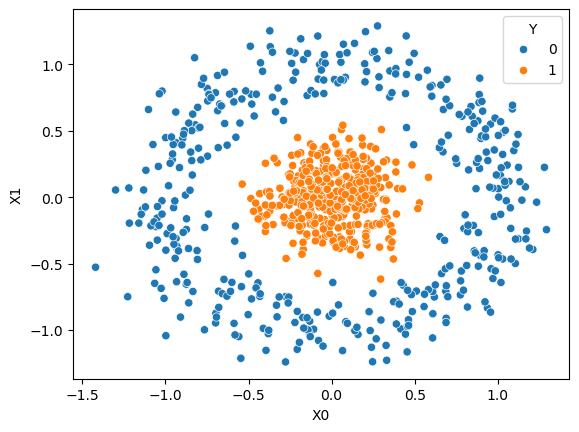

In [11]:
sns.scatterplot(dfTR, x=inputs[0], y=inputs[1], hue=output)
plt.show()

---

::: {.callout-note  icon=false}

### Adding New Features and Thinking about Dimensionality

From the geometry of this situation it shoud be clear that the decision boundary for this problem looks circle shaped. And the equation of a circle in the `X0, X1` plane is:

$$(X0 - a)^2 + (X1 - b)^2 = r^2$$

where $(a, b)$ is the center of the circle and $r$ its radius. This is a quadratic equation in `X0, X1`. So the situation looks like we could  apply the previous ideas to this setting if we add the quadratic terms in `X_0, X_1` that we need to write the circle eqution. We could add these as extra columnsas to the dataset, much as we did for logistic regression. Then the inputs in our model would be:

`1, X_0, X_1, X_0**2, X0 * X1, X1**2`

This are the coordinates of a point in a six dimensional space. The intuition behind this kind of transformations of the problem is that in a higher dimension it can become possible to find a separating linear hyperplane for the dataset.  

**Note:** adding a constant columns of ones to simplify some expression is a standard trick in many models, one that we will soon meet again in linear regression.

The following code will illustrate that in our current example, this can in fact be achieved by adding a single extra dimension (this has become a canonical introductory example for svm models). In order to this the code will fit a higher dimensional version of the kind of models we have been discussing.

:::

::: {.callout-warning  icon=false}


### Dynamic Visualization

The script below displays an interactive 3d plot to illustrate the preceding paragraph. In order to run this we need to install the `ipympl` module. Remember: open a terminal (Anaconda Prompot for Windows), activate the MLMIC24 environment and then run:  

`pip install ipympl`

Then uncomment and run the next two cells to see the 3d visualization. Finaly, when you are done run the third cell to return the graphic behavior of the notebook to its usual state. If you run into trouble, just leave the next cell commented (the magic matplotlib command one) and run the following ones.

:::

In [12]:
# %matplotlib widget

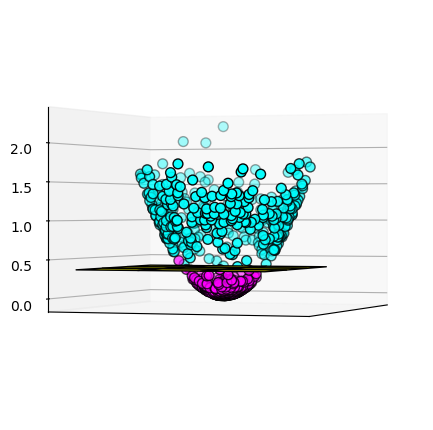

In [13]:
%run -i "./2_6_Glassner_Examples_06.py"

In [14]:
%matplotlib inline
plt.clf()

<Figure size 640x480 with 0 Axes>

This static plots summarize the idea that in three dimensional space the classes can be separated with a hyperplane.

![](./fig/Glassner-11-31.png){width=80% fig-align="center" fig-alt="Illustrating the Kernel Trick for SVM"}


---

::: {.callout-note  icon=false}

### Adding Higher order Terms Moves the Problem to Higher  Dimensions. 

The previous plots are helpful in building our intuition about how increased dimensions can help with linear separability. But how did the model actually achieve this? To understand this we need to understand what is called the **kernel trick**. And to get there we need a few preliminary steps.

First recall that we said we were adding quadratic terms to the model by considering the inputs to be
$$
1, X_0, X_1, X_0^2, X_0\,X_1, X_1^2
$$
And in doing so we have moved the classification problem to a six dimensional setting. But instead of doing exactly this we are going to **introduce a small rescaling**, writing:
$$
1, \underbrace{\sqrt{2} \, X_0}_{\textbf{rescaled!}}, \underbrace{\sqrt{2} \,X_1}_{\textbf{rescaled!}}, X_0^2, \underbrace{\sqrt{2} \, X_0\,X_1}_{\textbf{rescaled!}}, X_1^2
$$
The reason for this change will become apparent immediately. But it should be clear that this does not affect the essence of what we are doing.

::: 





::: {.callout-note  icon=false}

### The Decision Function in this Higher Dimensional Setting

Therefore, the function $f$ in the optimization problem changes from 

$$f(X_0, X_1)  = \beta_0 + \beta_1 X_0 + \beta_2 X_1$$

to this (the rescaling factors $\sqrt{2}$ can be absorbed into the $\beta$ coefficients): 

$$\tilde f(X_0, X_1) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_0^2 + \beta_4 X_0 X_1 + \beta_6 X_1^2$$

But the theoretical results that we introduced before prove that this function can be expressed as a sum (over the support vectors) of inner products:

$$\tilde f(X_0, X_1) = \beta_0 + \sum_{\bar X_i\in\mathcal S}\alpha_i \bar X_i^{(6)}\cdot \bar X^{(6)}$$

Each product $\bar X^{(6)}\cdot \bar X_i^{(6)}$ is the inner product of two six dimensional vectors (we have added this $(6)$ index to help you keep track of the dimensionality ). One corresponds to a support vector and the other to a new data point that is getting predicted. Suppose that the original coordinates of those points are $\bar X_i^{(2)} =(a, b)$ (for the support vector) and $\bar X^{(2)} =(x_0, x_1)$ (for the new point). Then the product is:
$$\bar X_i^{(6)}\cdot \bar X^{(6)} = (1, \sqrt{2} \,a, \sqrt{2} \,b, a^2, \sqrt{2} \, a\, b, b^2)\cdot (1, \sqrt{2} \,x_0, \sqrt{2} \,x_1, x_0^2, \sqrt{2} x_0 x_1, x_1^2) 
= 1 + 2a x_0 + 2 b x_1 + a^2 x_0^2 + 2 a b x_0 x_1 +  b^2 x_1^2 $$
That is a lot of computation! And we are only considering second order terms.



:::

::: {.callout-tip  icon=false}

### Exercise 003

How many products do you need to perform to compute the above expression, starting from the original $(a, b)$ and $(x_0, x_1)$?

:::

---

::: {.callout-note  icon=false}

### The Kernel Trick

Let us go back to the last expression.

$$
\bar X_i^{(6)}\cdot \bar X^{(6)} = 1 + 2a x_0 + 2 b x_1 + a^2 x_0^2 + 2 a b x_0 x_1 +  b^2 x_1^2
$$

And consider the **kernel function** defined **in the original dimension** as follows:
$$
K(\bar X_i^{(2)}, \bar X^{(2)} ) = K((a, b), (x_0, x_1)) = \left(1 + \bar X_i\cdot \bar X \right)^2
$$
That is:
$$
K(\bar X_i^{(2)}, \bar X^{(2)} ) = \left(1 + a x_0 + b x_1\right)^2 = 1 + 2 a x_0 + 2 b x_1 + a^2 x_0^2 + 2 a b x_0 x_1 + b^2 x_1^2  
$$
**The result is the same!** Therefore, we can use this to rewrite the function $f$ as follows:
$$\tilde f(X_0, X_1) = \beta_0 + \sum_{\bar X_i\in\mathcal S}\alpha_i\, K(\bar X_i^{(2)}, \bar X^{(2)})$$
with (low-dimensional) kernel values replacing (high-dimensional) dot products.

But in this version, starting from the two dimensional points:

+ We do not need to explicitly compute the extra feature columns with quadratic terms. That improves the memory requirements of the model. 
+ We only need three products to compute $\left(1 + a x_0 + b x_1\right)^2$. That is a *big* computational improvement. 

Recall that our dataset is bidimensional. As the number of variables in the dataset increases, this properties becomes more and more important.

This is an instance of the **kernel trick.** It allows the model to search for separating hyperplanes using all the possibilities of a higher dimensional space. But without having to explicitly do the compùtations there. All computing is done in the original dataset dimension. 

:::

---

::: {.callout-note  icon=false}

### Polynomial Kernels

The kernel function 
$$K(\bar X_i^{(2)}, \bar X^{(2)} ) = \left(1 + \bar X_i^{(2)}\cdot \bar X^{(2)} \right)^2$$  
that we used above is an example of a polynomial kernel of degree $d = 2$. In general the **polynomial kernel of degree $d$** is defined as
$$K(\bar X_i^{(2)}, \bar X^{(2)} ) = \left(1 + \bar X_i^{(2)}\cdot \bar X^{(2)} \right)^d$$  

If adding polynomial features of degree $d$ of the inputs is what the model needs, then we use this polynomial kernel (you can also select $d$ using a grid search). 

The following figure shows how we have used the symbolic skills of Matlab to check that the kernel trick for degree 3 polynomials works in a very similar way. The last input line is the kernel trick in this case. And you can check that we still only need four products when using the kernel trick.

:::

![](./fig/2_6_Matlab_KernelTrick_Poly3.png){width=90% fig-align="center" fig-alt="Using Matlab to illustrate the Kernel Trick for polynomial kernel of degree 3"}

**Note:** By the way, Python also has symbolic skills, using [SymPy](https://www.sympy.org/), so you could (learn a little SymPy and) check this result with Python as well.


---

::: {.callout-note  icon=false}

### Support Vector Machines. Implementation in scikit.

A **support vector machine (SVM)** is precisely this type of classifier model that combines the basic *support vector classifier (that uses hyperplanes and incorporates the penalty parameter C)* with a kernel function (that allows to search for separating hyperplanes in higher dimensions).

To use SVM models with scikit look at the [SVC class](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (the C in SVC stands for classification). 

:::



::: {.callout-tip  icon=false}

### Exercise 004

By now we have seen enough different models in scikit that you should be becoming familiar with the framework. To practice with the `SVC` class:

+ Load the code for `2_6_Glassner_Examples_06.py` and examine the part corresponding to the SVM model fit (identified in the code).
+ Get the training and test scores for the fitted  model.  
+ What values of the hyperparameters of the model were selected in the grid search?
+ Can you use `mltools` to make a plot illustrating the grid search?
+ By now this should be a routine; do a performance analysis of the model. 

:::

---



::: {.callout-note  icon=false}

### Looking at the Model's Decision Function iBack in the Dataset DImension

The decision function in this example now uses quadratic terms in the variables:
$$\tilde f(X_0, X_1) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_0^2 + \beta_4 X_0 X_1 + \beta_6 X_1^2$$
But is still a function of the (in this example) two dimensional data set. Therefore it can be used to define a decision boundary in the same way as we did with linear hyperplanes. 

The following code fragment does just that for the (polynomial kernel) SVM model that we have fit. The decision boundary divides the plane in two regions (with different shades of green) corresponding to the class predictions. You shouls see how this is a consequence of the 3d visualization that we did vefore. 



:::

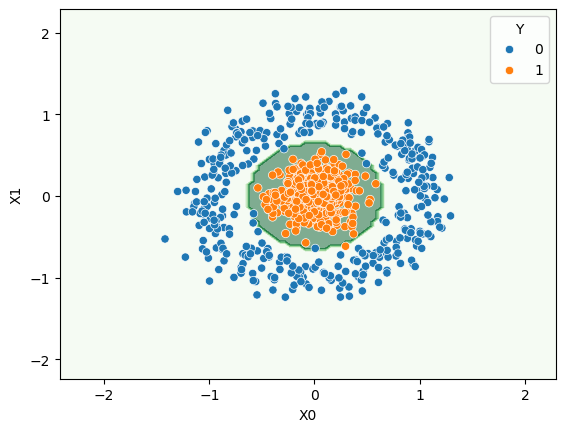

In [15]:
disp = DecisionBoundaryDisplay.from_estimator(model, XTR, response_method="predict", cmap="Greens", alpha = 0.5)
sns.scatterplot(dfTR, x=inputs[0], y=inputs[1], hue=output)
plt.show()

---


::: {.callout-note  icon=false}

### Moving Beyond Polynomials. 

Polynomials are sometimes too limited and rigid to find complicated decision boundaries. To illustrate this problem  and look for a solution we will use yet another dataset as example. 


:::

In [16]:
# Load the data
df = pd.read_csv('./spirals.csv', sep=',')
df.head(4)

,X0,X1,Y
0,1.332844,0.400201,0
1,-1.557642,0.124687,0
2,0.283394,-1.074328,0
3,0.263296,0.022294,1


In [17]:
inputs = ["X0", "X1"]
output = "Y"

X = df[inputs]
Y = df[output]

XTR, XTS, YTR, YTS = train_test_split(X, Y,
									  test_size=0.2,  # percentage preserved as test data
									  random_state=1, # seed for replication
									  stratify = Y)   # Preserves distribution of y

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

Let us visualize the data points to see where the dataset got its name.  

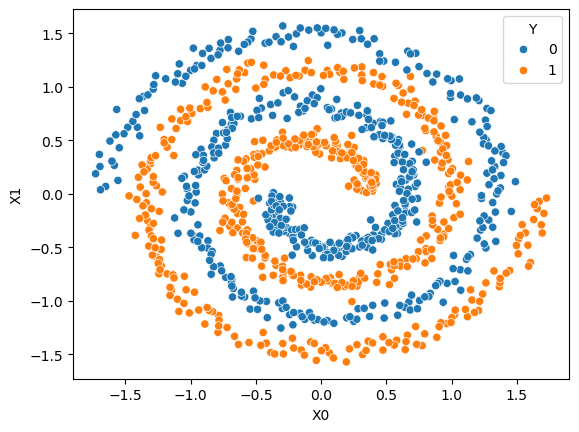

In [18]:
sns.scatterplot(dfTR, x=inputs[0], y=inputs[1], hue=output)
plt.show()

---


::: {.callout-note  icon=false}

### Moving Beyond Polynomials. The Radial Kernel.

**Note:** from this point, it should be clear that whenever we use a kernel function, we apply it to the feature vectors in the original dataset dimension. Therefore when writing a kernel value  we will be dropping the index 2 as in $\bar X^{(2)}$.

In order to deal with this example we will use a different kernel, defined as:
$$
K(\bar X_i, \bar X ) = \exp\left(-\dfrac{\|\bar X_i - \bar X\|^2}{2\sigma^2}\right)
$$
where, as usual  $\|\bar X_i - \bar X\|^2 = (\bar X_i - \bar X)\cdot (\bar X_i - \bar X)$. 

You surely have met the exponential function $e^{-u^2}$ before. It is the famous Gaussian bell shaped curve, that makes one  of its stellar appearances in the density of a normal random variable. We know that this function concentrates the mass around its center, and quickly drops to zero as we move far from the center. The $\sigma$ parameter controls the speed or radius of the decay.

To see how this kernel works remember that using the kernel trick we can rewrite the decision function as
$$\tilde f(\bar X) = \beta_0 + \sum_{\bar X_i\in\mathcal S}\alpha_i\, K(\bar X_i, \bar X)$$
with one term in the sum for every support vector in the dataset. In the case of the radial kernel only those support vectors close enough to $\bar X$ will make a significant contribution to the sum, because of the quick decay of the exponential. 

This implies that the radial kernel shows a **local (neighbor-based) behavior**, with the size of the neighborhood being controlled by $\sigma$. We can therefore consider $\sigma$ as a hyperparameter to be adjusted in a grid search.


:::

---


::: {.callout-note  icon=false}

### SVM with Radial Kernel in scikit.

The [SVC class](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) in scikit allows the use of radial kernels with the option `kernel = 'rbf'` (from *radial basis function*). The `gamma` parameter of the `SVC` class plays a similar role to the hyperparameter $\sigma$ above. Therefore both `C` (penalty parameter) and `gamma` are obvious targets for grid searches in radial kernels. 

The code below shows how to apply this kernel to the current example dataset.

:::

In [19]:
hyp_grid = {'SVM_rbf__C': 10.**np.arange(-3, 3, 1),
            'SVM_rbf__gamma': 10.**np.arange(0, 2, 0.25)}

SVM_rbf_pipe = Pipeline(steps=[ ('scaler', StandardScaler()), 
                        ('SVM_rbf',  SVC(kernel='rbf', 
                                    probability=True, 
                                    random_state=1))]) 


num_folds = 10

SVM_rbf_gridCV = GridSearchCV(estimator=SVM_rbf_pipe, 
                        param_grid=hyp_grid, 
                        cv=num_folds,
                        return_train_score=True,
                        n_jobs=-1)



We fit the model

In [20]:
model = SVM_rbf_gridCV
model.fit(XTR, YTR)

,estimator,Pipeline(step...om_state=1))])
,param_grid,"{'SVM_rbf__C': array([1.e-03...e+01, 1.e+02]), 'SVM_rbf__gamma': array([ 1. ... 56.23413252])}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


Check the selected values of `gamma` and `C`

In [21]:
model.best_params_

{'SVM_rbf__C': np.float64(1.0), 'SVM_rbf__gamma': np.float64(10.0)}

and the results in the training and test sets:

In [22]:
model.score(XTR, YTR), model.score(XTS, YTS)

(0.996875, 0.9958333333333333)

---


::: {.callout-note  icon=false}

### Displaying the Decision Boundary of a Radial Kernel SVM Model

The plot below shows how the local behavior of this kernel allows it to describe the shape of this dataset closely.

:::

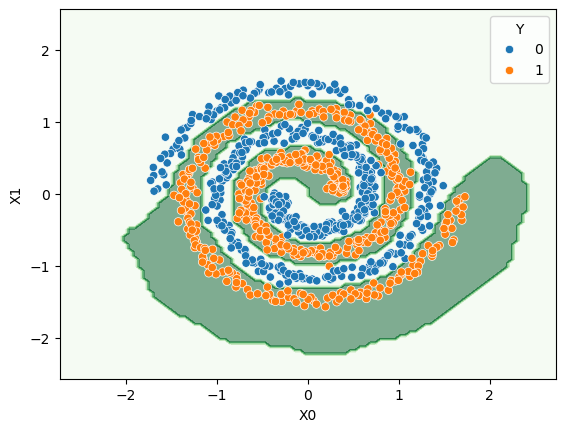

In [23]:
disp = DecisionBoundaryDisplay.from_estimator(model, XTR, response_method="predict", cmap="Greens", alpha = 0.5)
sns.scatterplot(dfTR, x=inputs[0], y=inputs[1], hue=output)
plt.show()

---


::: {.callout-note  icon=false}

### Polynomial vs Radial Kernel Decision Boundaries

The following figure (Figure 9-9, p.381 of [@ISLP2023]) illustrates the expected differences between a radial kernel (right panel) with local behavior and a polymomial kernel of degree 3 (left panel): note the clearly non local behavior of the boundary for this polynomial kernel. 

:::

![](./fig/2_2_ISLP_Fig9_9_SVM_radial_vs_Poly.png){width=60% fig-align="center" fig-alt="SVM Radial vs Polynomial Kernel Decision Boundaries"}

---


::: {.callout-note  icon=false}

### A Final Comment about the Radial Kernel and Infinite Dimensional Feature Spaces

We have discussed how the polynomial kernel manages to compute dot products between vectors  in a higher dimensional feature space. How does the radial kernel fit into this? Using the Taylor series expansion of the exponential, the radial kernel can be expressed as an infinite sum:
$$
\exp\left(-\dfrac{\|\bar X_i - \bar X\|^2}{2\sigma^2}\right) = 
1 - \dfrac{\|\bar X_i - \bar X\|^2}{2\sigma^2} + \dfrac{\|\bar X_i - \bar X\|^4}{4\sigma^4 \cdot 2!} - \dfrac{\|\bar X_i - \bar X\|^6}{2^3\sigma^6 \cdot 3!} + \cdots
$$
Remembering the discussion about polynomial kernels this can be interpreted as meaning that the radial kernel has terms of infinite degree. But the different degrees get weights so we recover the local behavior we have discussed. Once  again the kernel trick is allowing us to access this infinite dimensional feature space while keeping the computations in the original dimension. 

:::

---

::: {.callout-note  icon=false}

## In the Next Session

We will begin the discussion of regression models with the classical linear regresion model. 

:::

---

::: {.callout-note  icon=false}

### Recommended reading:

See [References](#References) section at the end for details.

+ Chapter 9 of [@ISLP2023]
+ Chapter 2 (pp.58-60 and pp.94-103) of [@IMLPY]
+ Chapter 5 of [@PDSH], [see here](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)
+ Chapter 12 of [@serrano2021grokking]
+ We will be using code and several figures from Chapter 11 of [@glassnerVisual2021], under [MIT license](https://github.com/blueberrymusic/Deep-Learning-A-Visual-Approach/blob/main/Notebooks/LICENSE). See the [GitHub repo](https://github.com/blueberrymusic/Deep-Learning-A-Visual-Approach) for this book for the corresponding Jupyter notebooks. 
+ For a much more in-depth treatment of the mathematical concepts behind support vector machines see Chapter 12 of [@ESLI2009] or Chapter 17 of [@pml1].
+ A review paper on SVMs is [@Bennett2000].

:::

# References